# Deep Dive into One Sample

This section digs into the results for one sample and compares those results to a standard practice cutoff approach that designates outliers using Tukey's outlier rule ($Q3 + IQR * 1.5$).

In [39]:
import pickle
import pymc3 as pm
import pandas as pd
import numpy as np
import scipy.stats as st
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Select Sample

Sample is a Thyroid Carcinoma from TCGA

In [36]:
tumor = pd.read_hdf('/mnt/data/outlier/tumor.hd5')
gtex = pd.read_hdf('/mnt/data/outlier/gtex.hd5')
drug_genes = [x.strip() for x in open('/mnt/data/outlier/drug-genes.txt')]

In [32]:
sample_id = np.random.choice(tumor.index)
sample_id = 'TCGA-DJ-A2PX-01' # Selected randomly but hardcoded here to reproduce figures in paper
sample = tumor.loc[sample_id]
sample.subtype

'Thyroid_Carcinoma'

## Select Gene Candidates

These 4 genes were selected to illustrate instances where an N-of-1 sample is close to the cutoff but may or may not actually be an outlier. 

In [11]:
def iqr_bounds(ys, whis: float = 1.5):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * whis)
    upper_bound = quartile_3 + (iqr * whis)
    return lower_bound, upper_bound

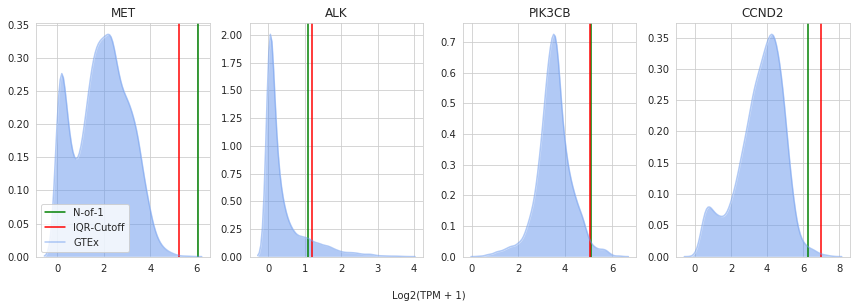

In [13]:
candidates = ['MET', 'ALK', 'PIK3CB', 'CCND2']
f, ax = plt.subplots(1, 4, figsize=(12, 4))
ax = ax.flatten()
for i, gene in enumerate(candidates):
    _, upper = iqr_bounds(gtex[gene])
    ax[i].axvline(sample[gene], label='N-of-1', c='g')
    ax[i].axvline(upper, c='r', label='IQR-Cutoff')
    sns.kdeplot(gtex[gene], label='GTEx', ax=ax[i], shade=True, alpha=0.5, color='cornflowerblue')
    ax[i].set_title(gene)
    if i != 0:
        ax[i].get_legend().remove()
f.text(0.5, -0.05, 'Log2(TPM + 1)', ha='center') 
plt.tight_layout()

## Load Model

In [16]:
sample_dir = '/mnt/outlier-runs/example-for-paper/TCGA-DJ-A2PX-01/'
with open(os.path.join(sample_dir, 'model.pkl'), 'rb') as buff:
    data = pickle.load(buff)
m, t = data['model'], data['trace']

## Traceplot
Trace plot shows the convergence of our $\beta$ parameter as well as the Laplacian error $\epsilon$. 

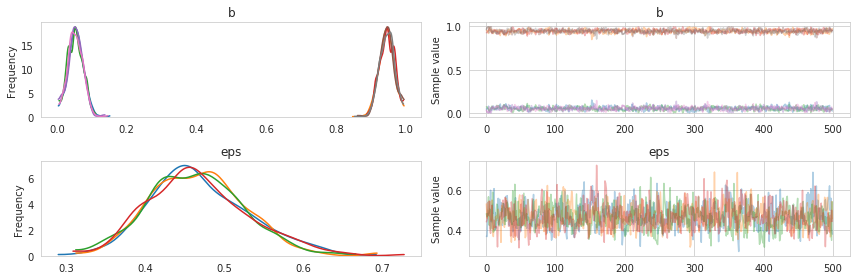

In [30]:
pm.traceplot(t, varnames=['b', 'eps']);

## Weights

The p-values in the model converged (Pearson correlation > 0.99) after only two tissues, one of which is Thyroid normal in GTEx.

In [20]:
def calculate_weights(classes, trace):
    class_col = []
    for c in classes:
        class_col.extend([c for _ in range(len(trace['a']))])

    weight_by_class = pd.DataFrame({'Class': class_col,
                                    'Weights': np.array([trace['b'][:, x] for x in range(len(classes))]).ravel()})
    return weight_by_class

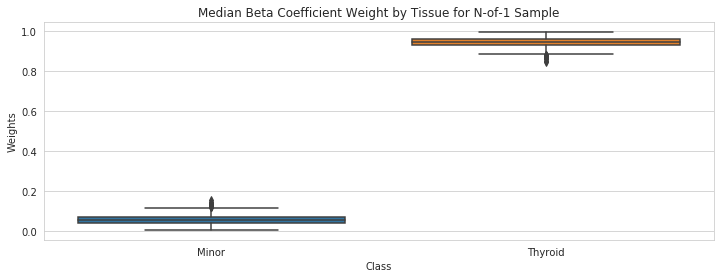

In [28]:
weights = calculate_weights(classes=['Minor', 'Thyroid'], trace=t)
plt.figure(figsize=(12, 4))
sns.boxplot(data=weights, x='Class', y='Weights')
plt.title('Median Beta Coefficient Weight by Tissue for N-of-1 Sample');

## Posterior Predictive Check

We'll calculate the posterior predictive distribution for each gene by multiplying our $\beta$ values by the trace values for $x_{d,g}$. We then add Laplacian error $\epsilon$ to the expected expression. Posterior predictive p-values are generated by comparing the N-of-1 sample to this posterior distribution and calculating the percentage of samples in the distribution larger than the N-of-1. 

In [42]:
def ppc(trace, genes):
    d = {}
    for gene in genes:
        d[gene] = _gene_ppc(trace, gene)
    return d

def _gene_ppc(trace, gene):
    y_gene = [x for x in trace.varnames if x.startswith(f'{gene}=')]
    b = trace['a']
    if 'b' in trace.varnames:
        for i, y_name in enumerate(y_gene):
            b += trace['b'][:, i] * trace[y_name]
    # If no 'b' in trace.varnames then there was only one comparison group
    else:
        for i, y_name in enumerate(y_gene):
            b += 1 * trace[y_name]
    ppc = st.laplace.rvs(loc=b, scale=trace['eps'])
    return st.laplace.rvs(*st.laplace.fit(ppc), size=100_000)

def posterior_predictive_pvals(sample, ppc):
    pvals = {}
    for gene in ppc:
        z_true = sample[gene]
        z = ppc[gene]
        pvals[gene] = _ppp_one_gene(z_true, z)
    return pd.Series(pvals).sort_values()

def _ppp_one_gene(z_true, z):
    return round(np.sum(z_true < z) / len(z), 5)

In [43]:
ppc = ppc(t, drug_genes)
ppp = posterior_predictive_pvals(sample, ppc)

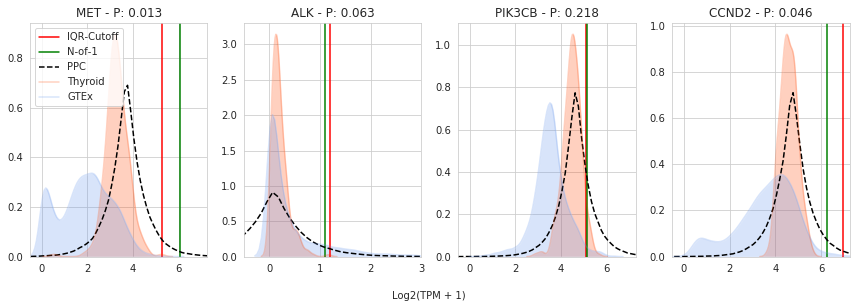

In [48]:
candidates = ['MET', 'ALK', 'PIK3CB', 'CCND2']
f, ax = plt.subplots(1, 4, figsize=(12, 4))
ax = ax.flatten()
for i, gene in enumerate(candidates):
    _, upper = iqr_bounds(gtex[gene])
    ax[i].axvline(upper, c='r', label='IQR-Cutoff')
    ax[i].axvline(sample[gene], c='g', label='N-of-1')
    sns.kdeplot(ppc[gene], label='PPC', ax=ax[i], ls='--', color='k')
    sns.kdeplot(gtex[gtex.tissue == sample.tissue][gene], ax=ax[i], shade=True, alpha=0.25, label=sample.tissue, color='orangered')
    sns.kdeplot(gtex[gene], label='GTEx', ax=ax[i], shade=True, alpha=0.25, color='cornflowerblue')
    ax[i].set_title(f'{gene} - P: {round(ppp[gene], 3)}')
    if i != 1:
        ax[i].set_xlim([-0.5, 7.25])
    else:
        ax[i].set_xlim([-0.5, 3])
    #ax[i].set_xlabel('Log2(TPM + 1)')
    if i != 0:
        ax[i].get_legend().remove()
    else:
        ax[i].legend(loc='upper left')
f.text(0.5, -0.05, 'Log2(TPM + 1)', ha='center')
plt.tight_layout()